# 📊 Exploratory Data Analysis: Pallet Box Counter

This notebook performs comprehensive EDA on the box detection datasets to understand:
1. Dataset composition and statistics
2. Box count distributions
3. Bounding box characteristics (size, aspect ratio, position)
4. Image quality analysis
5. Dataset comparison (Boxes vs Final_Object_Detection)

**Datasets:**
- Boxes.v1i.yolov8: 5,006 images
- Final_Object_Detection.v1i.yolov8: 1,869 images
- Combined: 6,875 images

**Split (70/20/10):**
- Train: 4,812 images
- Valid: 1,374 images
- Test: 689 images


## 1. Setup and Imports


In [1]:
import os
import sys
from pathlib import Path
import random

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image
import cv2

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


In [2]:
# Define paths
PROJECT_ROOT = Path('../').resolve()
DATASET1_PATH = PROJECT_ROOT / 'Boxes.v1i.yolov8'
DATASET2_PATH = PROJECT_ROOT / 'Final_Object_Detection.v1i.yolov8'

print(f"Project Root: {PROJECT_ROOT}")
print(f"Dataset 1: {DATASET1_PATH.name} - Exists: {DATASET1_PATH.exists()}")
print(f"Dataset 2: {DATASET2_PATH.name} - Exists: {DATASET2_PATH.exists()}")


Project Root: /Users/qadeermac/workspace/ML-Pallet-Box-Counter
Dataset 1: Boxes.v1i.yolov8 - Exists: True
Dataset 2: Final_Object_Detection.v1i.yolov8 - Exists: True


## 2. Data Loading Functions


In [3]:
def parse_yolo_label(label_path):
    """
    Parse YOLO format label file.
    Format: class_id x_center y_center width height (normalized 0-1)
    
    Returns list of dicts with bbox info.
    """
    boxes = []
    if not label_path.exists():
        return boxes
    
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                boxes.append({
                    'class_id': int(parts[0]),
                    'x_center': float(parts[1]),
                    'y_center': float(parts[2]),
                    'width': float(parts[3]),
                    'height': float(parts[4])
                })
    return boxes


def load_dataset_info(dataset_path, dataset_name):
    """
    Load all image and annotation information from a dataset.
    Returns a DataFrame with one row per image.
    """
    data = []
    
    for split in ['train', 'valid', 'test']:
        images_dir = dataset_path / split / 'images'
        labels_dir = dataset_path / split / 'labels'
        
        if not images_dir.exists():
            continue
        
        for img_path in images_dir.glob('*.jpg'):
            label_path = labels_dir / f"{img_path.stem}.txt"
            boxes = parse_yolo_label(label_path)
            
            # Get image dimensions
            try:
                with Image.open(img_path) as img:
                    img_width, img_height = img.size
            except:
                img_width, img_height = None, None
            
            data.append({
                'dataset': dataset_name,
                'split': split,
                'image_path': str(img_path),
                'label_path': str(label_path),
                'image_name': img_path.name,
                'img_width': img_width,
                'img_height': img_height,
                'box_count': len(boxes),
                'boxes': boxes
            })
    
    return pd.DataFrame(data)


print("✓ Data loading functions defined")


✓ Data loading functions defined


In [4]:
# Load both datasets
print("Loading Dataset 1: Boxes.v1i.yolov8...")
df_boxes = load_dataset_info(DATASET1_PATH, 'Boxes')
print(f"  Loaded {len(df_boxes)} images")

print("\nLoading Dataset 2: Final_Object_Detection...")
df_final = load_dataset_info(DATASET2_PATH, 'Final_Object_Detection')
print(f"  Loaded {len(df_final)} images")

# Combine datasets
df_combined = pd.concat([df_boxes, df_final], ignore_index=True)
print(f"\n✓ Combined dataset: {len(df_combined)} images")


Loading Dataset 1: Boxes.v1i.yolov8...


  Loaded 5006 images

Loading Dataset 2: Final_Object_Detection...


  Loaded 1869 images

✓ Combined dataset: 6875 images


## 3. Dataset Overview


In [5]:
# Dataset composition summary
print("="*60)
print("DATASET COMPOSITION SUMMARY")
print("="*60)

# By dataset and split
summary = df_combined.groupby(['dataset', 'split']).agg({
    'image_name': 'count',
    'box_count': ['sum', 'mean', 'std', 'min', 'max']
}).round(2)

summary.columns = ['Images', 'Total Boxes', 'Avg Boxes/Image', 'Std', 'Min', 'Max']
print(summary)

# Overall statistics
print("\n" + "="*60)
print("OVERALL STATISTICS")
print("="*60)
total_images = len(df_combined)
total_boxes = df_combined['box_count'].sum()
print(f"Total Images: {total_images:,}")
print(f"Total Bounding Boxes: {total_boxes:,}")
print(f"Average Boxes per Image: {total_boxes/total_images:.2f}")


DATASET COMPOSITION SUMMARY
                              Images  Total Boxes  Avg Boxes/Image    Std  \
dataset                split                                                
Boxes                  test      501         7202            14.38  15.91   
                       train    3504        53336            15.22  17.26   
                       valid    1001        14565            14.55  16.32   
Final_Object_Detection test      188          440             2.34   2.54   
                       train    1308         3486             2.67   2.72   
                       valid     373          920             2.47   2.38   

                              Min  Max  
dataset                split            
Boxes                  test     1   91  
                       train    1   98  
                       valid    1   96  
Final_Object_Detection test     1   12  
                       train    1   23  
                       valid    1   12  

OVERALL STATISTICS
Total I

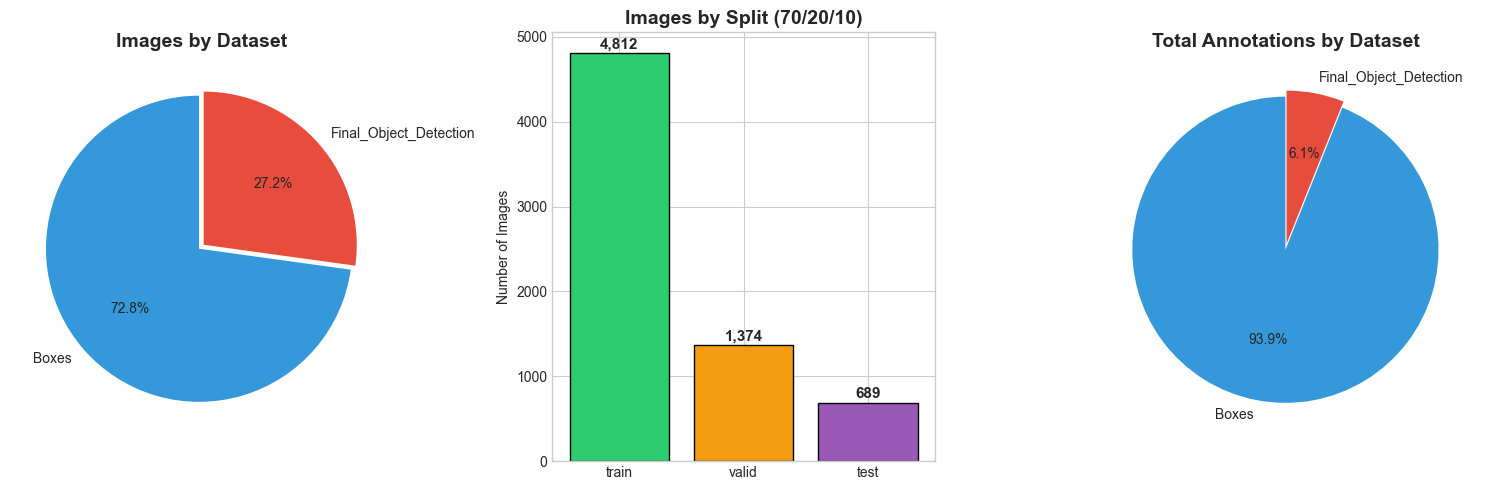


✓ Figure saved to docs/dataset_composition.png


In [6]:
# Visual: Dataset composition
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Images by dataset
dataset_counts = df_combined['dataset'].value_counts()
colors = ['#3498db', '#e74c3c']
axes[0].pie(dataset_counts, labels=dataset_counts.index, autopct='%1.1f%%', 
            colors=colors, explode=[0.02, 0.02], startangle=90)
axes[0].set_title('Images by Dataset', fontsize=14, fontweight='bold')

# Plot 2: Images by split
split_counts = df_combined['split'].value_counts().reindex(['train', 'valid', 'test'])
colors_split = ['#2ecc71', '#f39c12', '#9b59b6']
bars = axes[1].bar(split_counts.index, split_counts.values, color=colors_split, edgecolor='black')
axes[1].set_title('Images by Split (70/20/10)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Images')
for bar, count in zip(bars, split_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                 f'{count:,}', ha='center', fontsize=11, fontweight='bold')

# Plot 3: Boxes by dataset
boxes_by_dataset = df_combined.groupby('dataset')['box_count'].sum()
axes[2].pie(boxes_by_dataset, labels=boxes_by_dataset.index, autopct='%1.1f%%',
            colors=colors, explode=[0.02, 0.02], startangle=90)
axes[2].set_title('Total Annotations by Dataset', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../docs/dataset_composition.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved to docs/dataset_composition.png")


## 4. Box Count Distribution Analysis

**Key Question:** How many boxes are typically in each image? This determines model complexity needs.


In [7]:
# Box count statistics
print("="*60)
print("BOX COUNT DISTRIBUTION")
print("="*60)

stats = df_combined['box_count'].describe()
print(f"\nDescriptive Statistics:")
print(f"  Count:  {stats['count']:.0f} images")
print(f"  Mean:   {stats['mean']:.2f} boxes/image")
print(f"  Std:    {stats['std']:.2f}")
print(f"  Min:    {stats['min']:.0f}")
print(f"  25%:    {stats['25%']:.0f}")
print(f"  Median: {stats['50%']:.0f}")
print(f"  75%:    {stats['75%']:.0f}")
print(f"  Max:    {stats['max']:.0f}")

# Additional percentiles
print(f"\nAdditional Percentiles:")
for p in [90, 95, 99]:
    val = df_combined['box_count'].quantile(p/100)
    print(f"  {p}th percentile: {val:.0f} boxes")


BOX COUNT DISTRIBUTION

Descriptive Statistics:
  Count:  6875 images
  Mean:   11.63 boxes/image
  Std:    15.54
  Min:    1
  25%:    3
  Median: 6
  75%:    12
  Max:    98

Additional Percentiles:
  90th percentile: 30 boxes
  95th percentile: 45 boxes
  99th percentile: 82 boxes


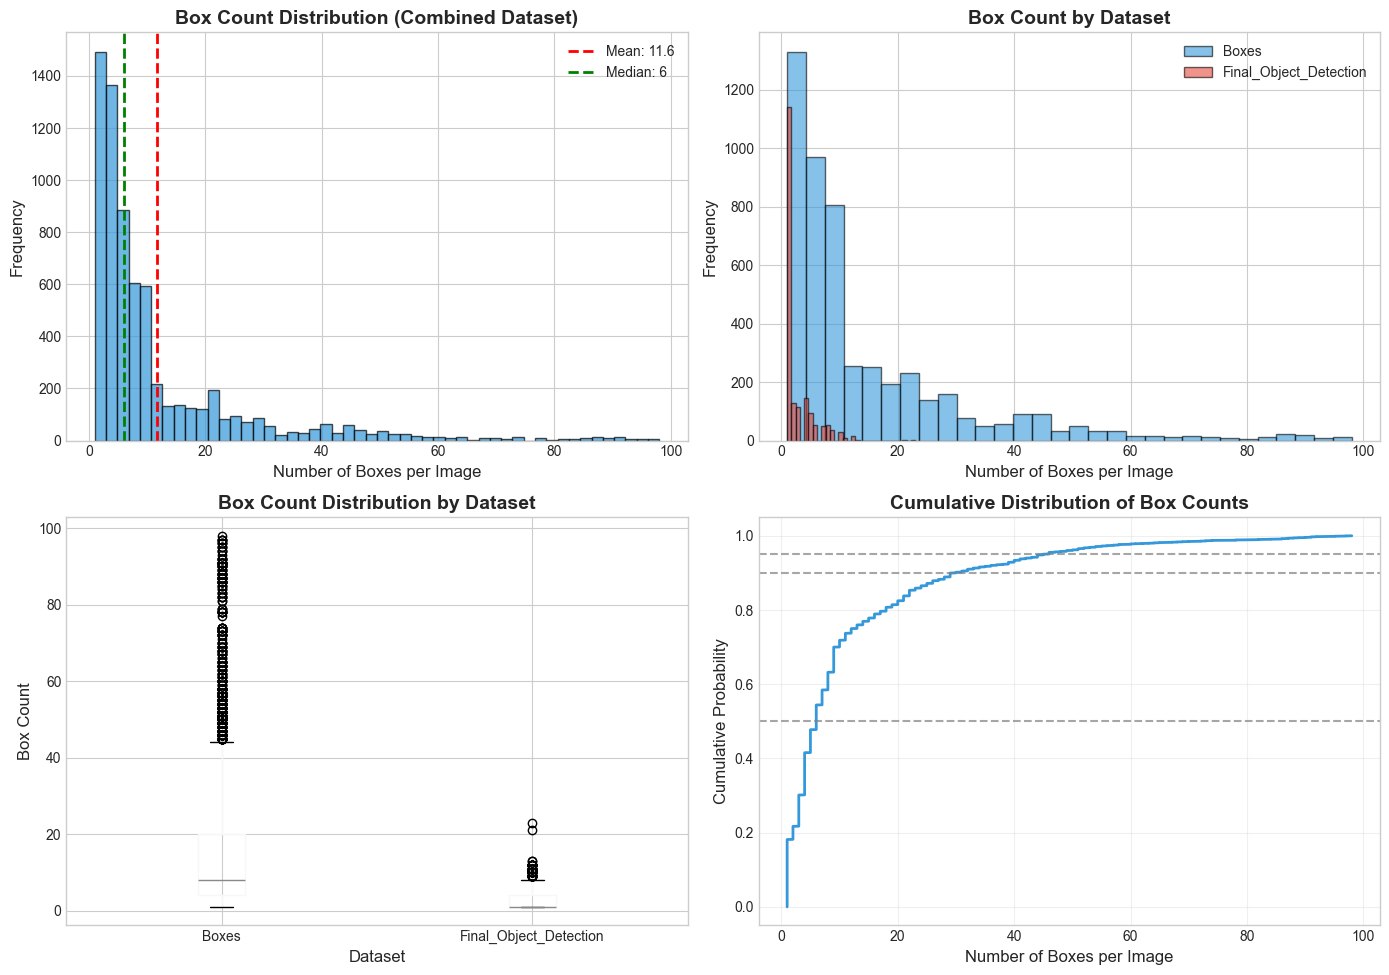


✓ Figure saved to docs/box_count_distribution.png


In [8]:
# Box count distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Overall histogram
ax1 = axes[0, 0]
ax1.hist(df_combined['box_count'], bins=50, edgecolor='black', alpha=0.7, color='#3498db')
ax1.axvline(df_combined['box_count'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df_combined['box_count'].mean():.1f}")
ax1.axvline(df_combined['box_count'].median(), color='green', linestyle='--', linewidth=2, label=f"Median: {df_combined['box_count'].median():.0f}")
ax1.set_xlabel('Number of Boxes per Image', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Box Count Distribution (Combined Dataset)', fontsize=14, fontweight='bold')
ax1.legend()

# Plot 2: By dataset comparison
ax2 = axes[0, 1]
for dataset, color in zip(['Boxes', 'Final_Object_Detection'], ['#3498db', '#e74c3c']):
    subset = df_combined[df_combined['dataset'] == dataset]['box_count']
    ax2.hist(subset, bins=30, alpha=0.6, label=dataset, color=color, edgecolor='black')
ax2.set_xlabel('Number of Boxes per Image', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Box Count by Dataset', fontsize=14, fontweight='bold')
ax2.legend()

# Plot 3: Box plot by dataset
ax3 = axes[1, 0]
df_combined.boxplot(column='box_count', by='dataset', ax=ax3)
ax3.set_xlabel('Dataset', fontsize=12)
ax3.set_ylabel('Box Count', fontsize=12)
ax3.set_title('Box Count Distribution by Dataset', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove automatic title

# Plot 4: CDF (Cumulative Distribution)
ax4 = axes[1, 1]
sorted_counts = np.sort(df_combined['box_count'])
cdf = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)
ax4.plot(sorted_counts, cdf, linewidth=2, color='#3498db')
ax4.axhline(0.5, color='gray', linestyle='--', alpha=0.7)
ax4.axhline(0.9, color='gray', linestyle='--', alpha=0.7)
ax4.axhline(0.95, color='gray', linestyle='--', alpha=0.7)
ax4.set_xlabel('Number of Boxes per Image', fontsize=12)
ax4.set_ylabel('Cumulative Probability', fontsize=12)
ax4.set_title('Cumulative Distribution of Box Counts', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/box_count_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved to docs/box_count_distribution.png")


In [9]:
# Identify potential outliers and edge cases
print("="*60)
print("EDGE CASE ANALYSIS")
print("="*60)

# Low box count images
low_count = df_combined[df_combined['box_count'] <= 2]
print(f"\nImages with ≤2 boxes: {len(low_count)} ({len(low_count)/len(df_combined)*100:.1f}%)")

# High box count images
high_threshold = df_combined['box_count'].quantile(0.95)
high_count = df_combined[df_combined['box_count'] >= high_threshold]
print(f"Images with ≥{high_threshold:.0f} boxes (top 5%): {len(high_count)} images")

# Zero box images (potential issues)
zero_count = df_combined[df_combined['box_count'] == 0]
if len(zero_count) > 0:
    print(f"\n⚠ WARNING: {len(zero_count)} images have NO annotations!")
    print("  These might be labeling errors or background images.")
else:
    print(f"\n✓ All images have at least one annotation.")

# Display extremes
print(f"\nTop 5 images by box count:")
top5 = df_combined.nlargest(5, 'box_count')[['dataset', 'image_name', 'box_count']]
print(top5.to_string(index=False))


EDGE CASE ANALYSIS

Images with ≤2 boxes: 1493 (21.7%)
Images with ≥45 boxes (top 5%): 356 images

✓ All images have at least one annotation.

Top 5 images by box count:
dataset                                                  image_name  box_count
  Boxes IMG_0263_mp4-78_jpg.rf.87708dd158e7f49af711aeedbfc8c647.jpg         98
  Boxes IMG_0263_mp4-78_jpg.rf.1afaddc28f0584ff5582847f32b3efb3.jpg         97
  Boxes IMG_0263_mp4-79_jpg.rf.724bb60cadabd49d3c6b51303155367b.jpg         97
  Boxes IMG_0263_mp4-78_jpg.rf.3fd67dff4622386e80c02066f836eb83.jpg         97
  Boxes IMG_0263_mp4-82_jpg.rf.9a275ce7817e6775db5fdc9de92dfe13.jpg         97


## 5. Bounding Box Characteristics


In [10]:
# Extract all bounding boxes into a flat DataFrame
bbox_data = []

for idx, row in df_combined.iterrows():
    for box in row['boxes']:
        bbox_data.append({
            'dataset': row['dataset'],
            'split': row['split'],
            'image_name': row['image_name'],
            'img_width': row['img_width'],
            'img_height': row['img_height'],
            'x_center': box['x_center'],
            'y_center': box['y_center'],
            'width': box['width'],
            'height': box['height'],
            'area': box['width'] * box['height'],  # Normalized area
            'aspect_ratio': box['width'] / box['height'] if box['height'] > 0 else 0
        })

df_bbox = pd.DataFrame(bbox_data)
print(f"✓ Extracted {len(df_bbox):,} bounding boxes")


✓ Extracted 79,949 bounding boxes


In [11]:
# Bounding box statistics
print("="*60)
print("BOUNDING BOX STATISTICS")
print("="*60)

print("\n📐 Size Statistics (normalized 0-1):")
print(f"  Width  - Mean: {df_bbox['width'].mean():.4f}, Std: {df_bbox['width'].std():.4f}")
print(f"  Height - Mean: {df_bbox['height'].mean():.4f}, Std: {df_bbox['height'].std():.4f}")
print(f"  Area   - Mean: {df_bbox['area'].mean():.4f}, Std: {df_bbox['area'].std():.4f}")

print("\n📏 Aspect Ratio Statistics:")
print(f"  Mean: {df_bbox['aspect_ratio'].mean():.3f}")
print(f"  Median: {df_bbox['aspect_ratio'].median():.3f}")
print(f"  Std: {df_bbox['aspect_ratio'].std():.3f}")

# Categorize box sizes
df_bbox['size_category'] = pd.cut(
    df_bbox['area'],
    bins=[0, 0.01, 0.05, 1.0],
    labels=['Small (<1%)', 'Medium (1-5%)', 'Large (>5%)']
)

print("\n📦 Box Size Categories:")
size_dist = df_bbox['size_category'].value_counts()
for cat, count in size_dist.items():
    print(f"  {cat}: {count:,} ({count/len(df_bbox)*100:.1f}%)")


BOUNDING BOX STATISTICS

📐 Size Statistics (normalized 0-1):
  Width  - Mean: 0.2495, Std: 0.2223
  Height - Mean: 0.2781, Std: 0.2342
  Area   - Mean: 0.1035, Std: 0.1638

📏 Aspect Ratio Statistics:
  Mean: 1.186
  Median: 0.952
  Std: 3.933

📦 Box Size Categories:
  Large (>5%): 31,803 (39.8%)
  Medium (1-5%): 30,385 (38.0%)
  Small (<1%): 17,759 (22.2%)


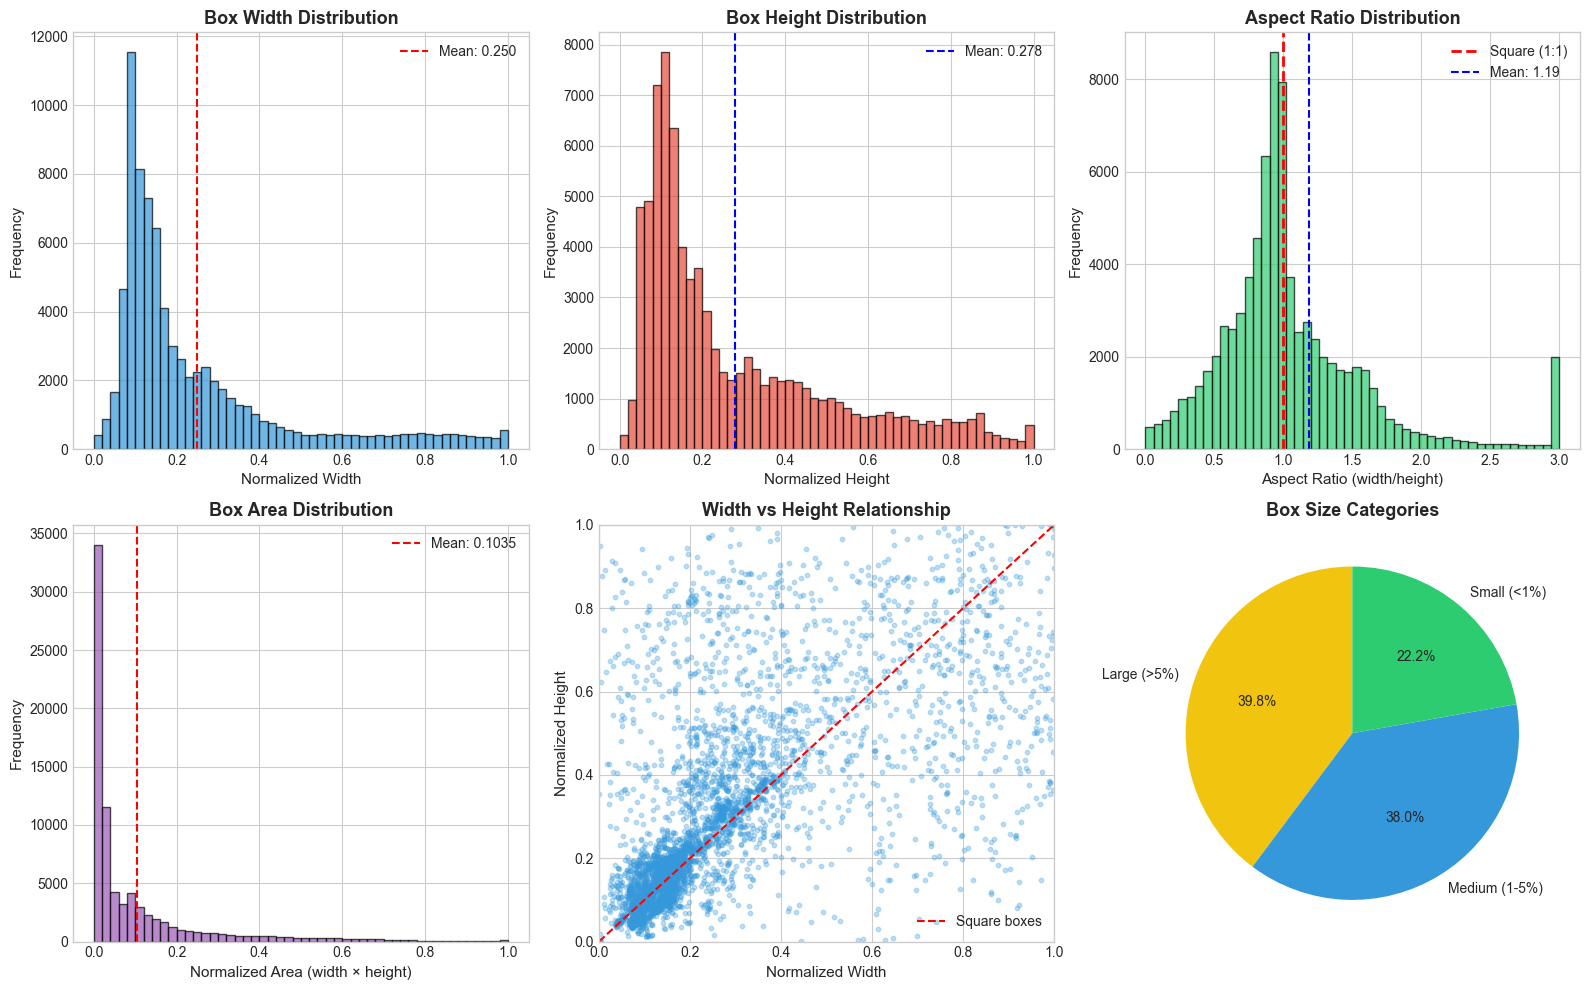


✓ Figure saved to docs/bbox_characteristics.png


In [12]:
# Bounding box visualizations
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot 1: Width distribution
ax1 = axes[0, 0]
ax1.hist(df_bbox['width'], bins=50, edgecolor='black', alpha=0.7, color='#3498db')
ax1.axvline(df_bbox['width'].mean(), color='red', linestyle='--', label=f"Mean: {df_bbox['width'].mean():.3f}")
ax1.set_xlabel('Normalized Width', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Box Width Distribution', fontsize=13, fontweight='bold')
ax1.legend()

# Plot 2: Height distribution
ax2 = axes[0, 1]
ax2.hist(df_bbox['height'], bins=50, edgecolor='black', alpha=0.7, color='#e74c3c')
ax2.axvline(df_bbox['height'].mean(), color='blue', linestyle='--', label=f"Mean: {df_bbox['height'].mean():.3f}")
ax2.set_xlabel('Normalized Height', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Box Height Distribution', fontsize=13, fontweight='bold')
ax2.legend()

# Plot 3: Aspect ratio distribution
ax3 = axes[0, 2]
ax3.hist(df_bbox['aspect_ratio'].clip(0, 3), bins=50, edgecolor='black', alpha=0.7, color='#2ecc71')
ax3.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Square (1:1)')
ax3.axvline(df_bbox['aspect_ratio'].mean(), color='blue', linestyle='--', label=f"Mean: {df_bbox['aspect_ratio'].mean():.2f}")
ax3.set_xlabel('Aspect Ratio (width/height)', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Aspect Ratio Distribution', fontsize=13, fontweight='bold')
ax3.legend()

# Plot 4: Area distribution
ax4 = axes[1, 0]
ax4.hist(df_bbox['area'], bins=50, edgecolor='black', alpha=0.7, color='#9b59b6')
ax4.axvline(df_bbox['area'].mean(), color='red', linestyle='--', label=f"Mean: {df_bbox['area'].mean():.4f}")
ax4.set_xlabel('Normalized Area (width × height)', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.set_title('Box Area Distribution', fontsize=13, fontweight='bold')
ax4.legend()

# Plot 5: Width vs Height scatter
ax5 = axes[1, 1]
sample = df_bbox.sample(min(5000, len(df_bbox)))
ax5.scatter(sample['width'], sample['height'], alpha=0.3, s=10, c='#3498db')
ax5.plot([0, 1], [0, 1], 'r--', label='Square boxes')
ax5.set_xlabel('Normalized Width', fontsize=11)
ax5.set_ylabel('Normalized Height', fontsize=11)
ax5.set_title('Width vs Height Relationship', fontsize=13, fontweight='bold')
ax5.legend()
ax5.set_xlim(0, 1)
ax5.set_ylim(0, 1)

# Plot 6: Size category pie chart
ax6 = axes[1, 2]
size_dist = df_bbox['size_category'].value_counts()
colors_size = ['#f1c40f', '#3498db', '#2ecc71']
ax6.pie(size_dist, labels=size_dist.index, autopct='%1.1f%%', colors=colors_size, startangle=90)
ax6.set_title('Box Size Categories', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../docs/bbox_characteristics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved to docs/bbox_characteristics.png")


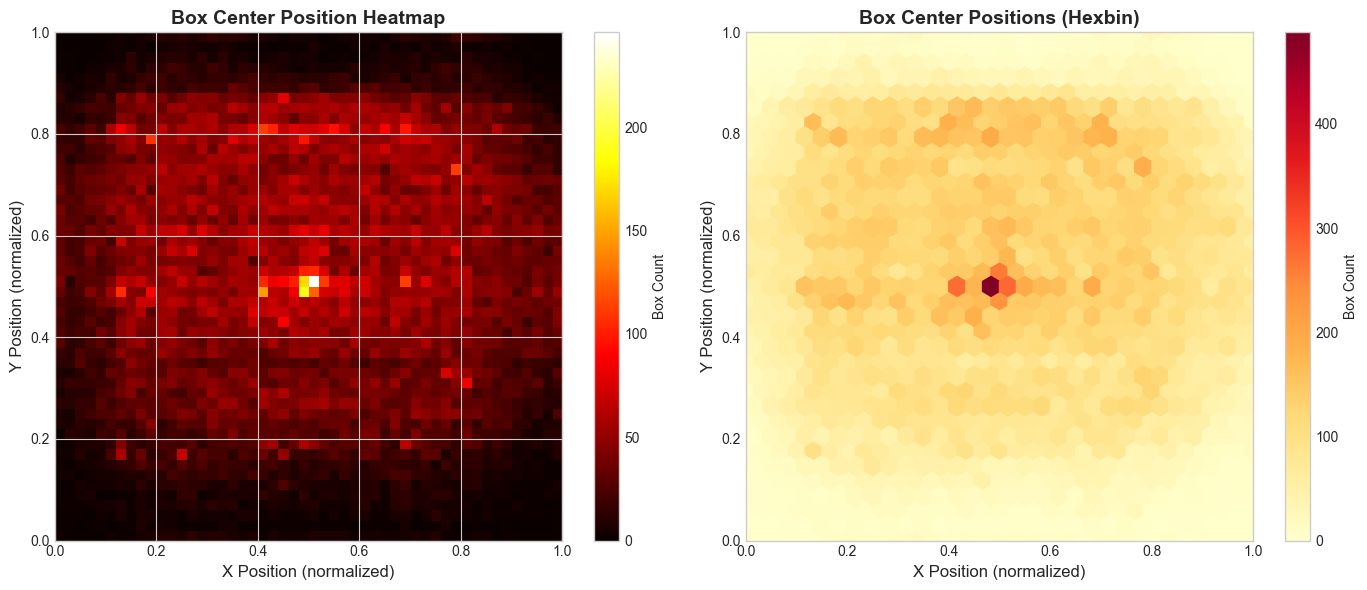


✓ Figure saved to docs/bbox_position_heatmap.png


In [13]:
# Box position heatmap (where boxes appear in images)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heatmap of box centers
ax1 = axes[0]
heatmap, xedges, yedges = np.histogram2d(
    df_bbox['x_center'], 
    df_bbox['y_center'],
    bins=50,
    range=[[0, 1], [0, 1]]
)
im = ax1.imshow(heatmap.T, origin='lower', extent=[0, 1, 0, 1], 
                cmap='hot', aspect='auto')
plt.colorbar(im, ax=ax1, label='Box Count')
ax1.set_xlabel('X Position (normalized)', fontsize=12)
ax1.set_ylabel('Y Position (normalized)', fontsize=12)
ax1.set_title('Box Center Position Heatmap', fontsize=14, fontweight='bold')

# Hex bin plot
ax2 = axes[1]
hb = ax2.hexbin(df_bbox['x_center'], df_bbox['y_center'], gridsize=30, cmap='YlOrRd')
plt.colorbar(hb, ax=ax2, label='Box Count')
ax2.set_xlabel('X Position (normalized)', fontsize=12)
ax2.set_ylabel('Y Position (normalized)', fontsize=12)
ax2.set_title('Box Center Positions (Hexbin)', fontsize=14, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('../docs/bbox_position_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved to docs/bbox_position_heatmap.png")


## 6. Sample Image Visualizations


In [14]:
def visualize_image_with_boxes(image_path, boxes, ax, title=None):
    """
    Display image with bounding box overlays.
    """
    img = Image.open(image_path)
    img_width, img_height = img.size
    
    ax.imshow(img)
    
    for box in boxes:
        # Convert normalized coords to pixel coords
        x_center = box['x_center'] * img_width
        y_center = box['y_center'] * img_height
        width = box['width'] * img_width
        height = box['height'] * img_height
        
        # Convert to corner coordinates
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        
        # Draw rectangle
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)
    
    if title:
        ax.set_title(title, fontsize=11, fontweight='bold')
    ax.axis('off')

print("✓ Visualization function defined")


✓ Visualization function defined


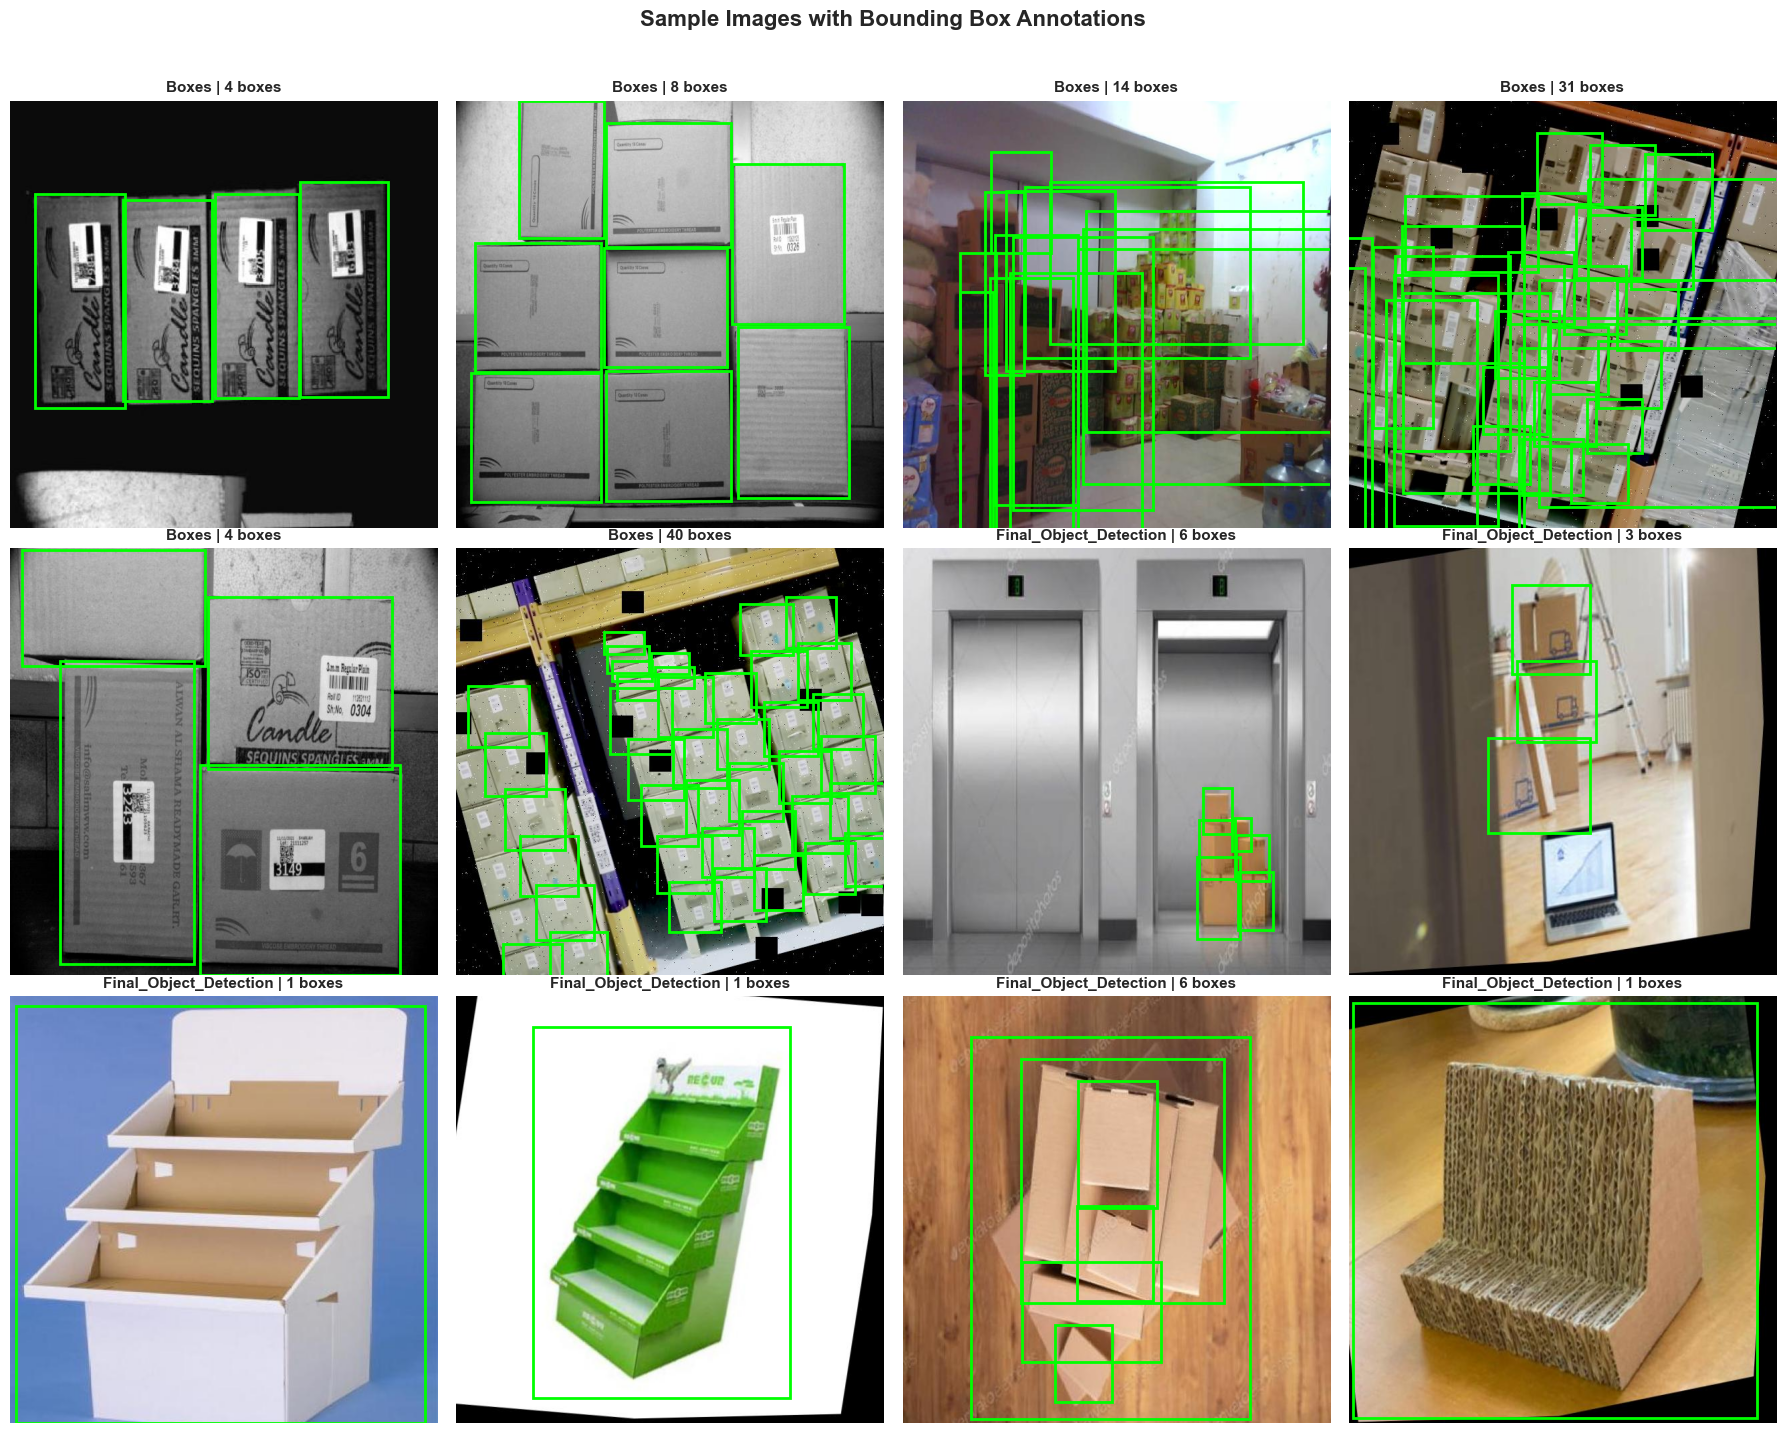


✓ Figure saved to docs/sample_images.png


In [15]:
# Show random samples from each dataset
fig, axes = plt.subplots(3, 4, figsize=(18, 14))

# Sample from Dataset 1
samples_d1 = df_boxes.sample(6)
# Sample from Dataset 2  
samples_d2 = df_final.sample(6)

all_samples = pd.concat([samples_d1, samples_d2])

for idx, (ax, (_, row)) in enumerate(zip(axes.flatten(), all_samples.iterrows())):
    title = f"{row['dataset']} | {row['box_count']} boxes"
    visualize_image_with_boxes(row['image_path'], row['boxes'], ax, title)

plt.suptitle('Sample Images with Bounding Box Annotations', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../docs/sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved to docs/sample_images.png")


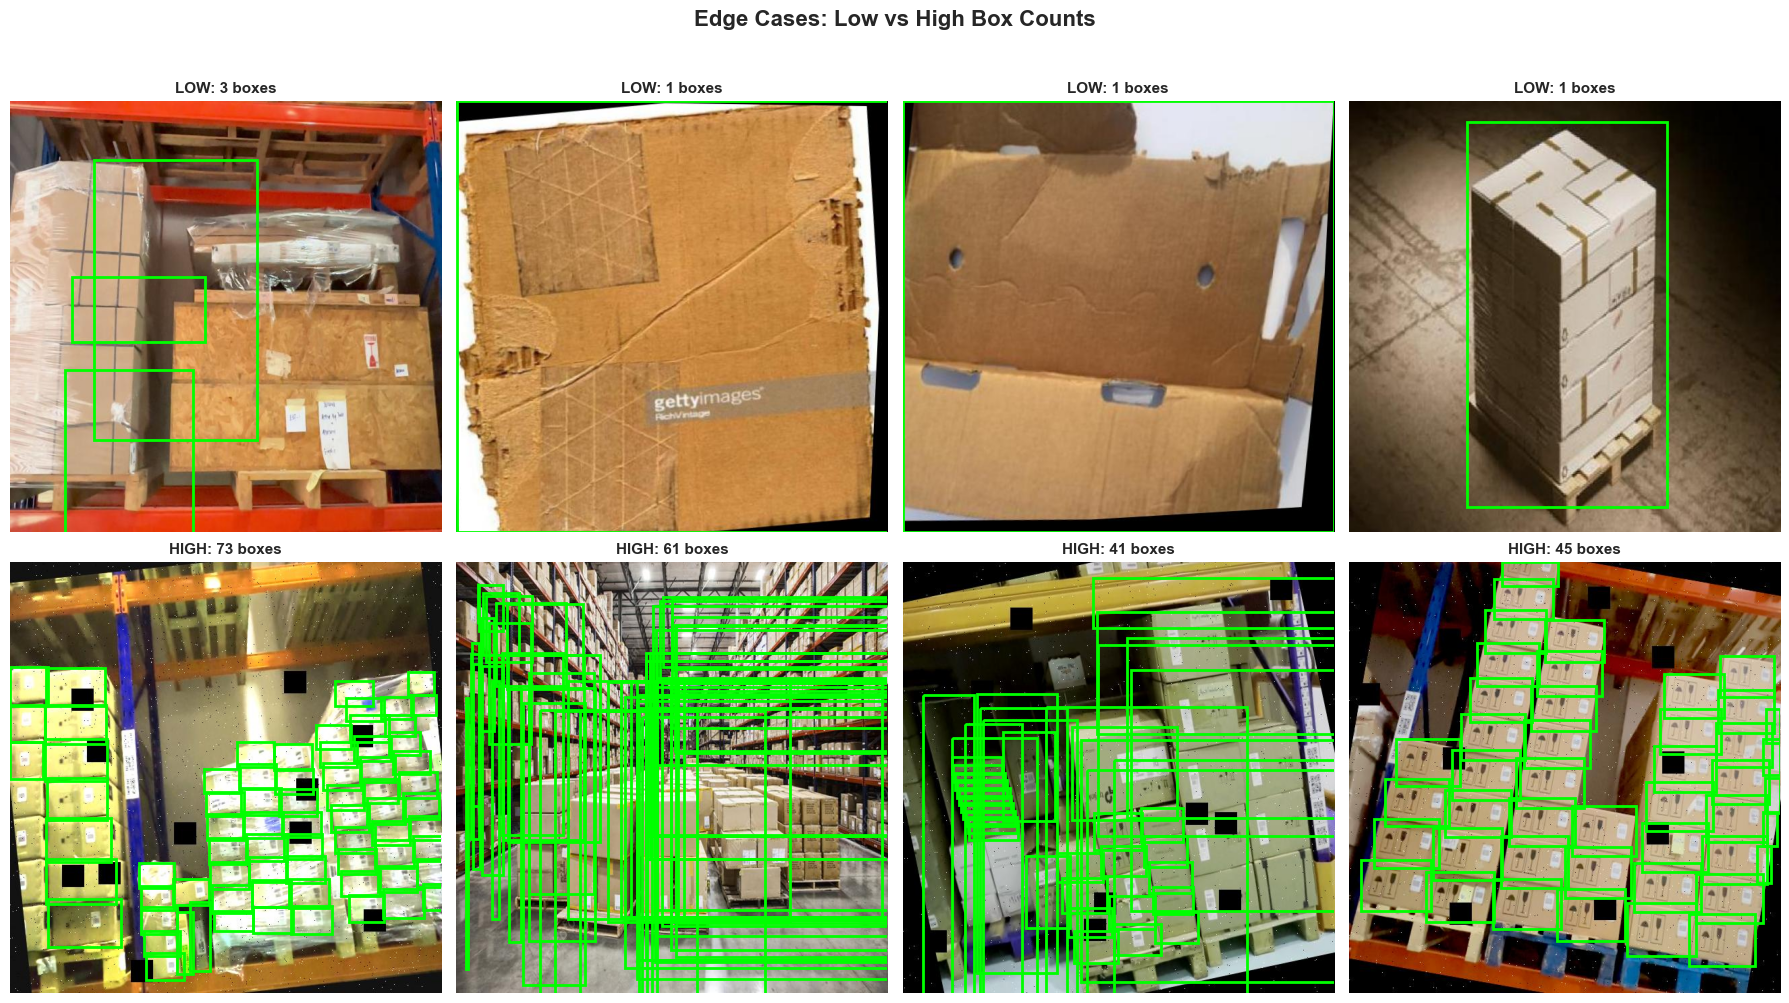


✓ Figure saved to docs/edge_cases.png


In [16]:
# Show edge cases: low and high box counts
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# Low box count examples (1-3 boxes)
low_samples = df_combined[df_combined['box_count'].between(1, 3)].sample(min(4, len(df_combined[df_combined['box_count'].between(1, 3)])))

# High box count examples
high_threshold = df_combined['box_count'].quantile(0.9)
high_samples = df_combined[df_combined['box_count'] >= high_threshold].sample(4)

# Plot low count samples
for idx, (ax, (_, row)) in enumerate(zip(axes[0], low_samples.iterrows())):
    title = f"LOW: {row['box_count']} boxes"
    visualize_image_with_boxes(row['image_path'], row['boxes'], ax, title)

# Plot high count samples
for idx, (ax, (_, row)) in enumerate(zip(axes[1], high_samples.iterrows())):
    title = f"HIGH: {row['box_count']} boxes"
    visualize_image_with_boxes(row['image_path'], row['boxes'], ax, title)

plt.suptitle('Edge Cases: Low vs High Box Counts', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../docs/edge_cases.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved to docs/edge_cases.png")


## 7. Image Quality Analysis


In [17]:
def analyze_image_quality(image_path):
    """
    Analyze image quality metrics: brightness, contrast, resolution.
    """
    img = cv2.imread(str(image_path))
    if img is None:
        return None
    
    # Convert to grayscale for analysis
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return {
        'brightness': np.mean(gray),
        'contrast': np.std(gray),
        'height': img.shape[0],
        'width': img.shape[1]
    }

# Sample images for quality analysis
print("Analyzing image quality (sampling 500 images)...")
quality_sample = df_combined.sample(min(500, len(df_combined)))

quality_data = []
for _, row in quality_sample.iterrows():
    metrics = analyze_image_quality(row['image_path'])
    if metrics:
        metrics['dataset'] = row['dataset']
        quality_data.append(metrics)

df_quality = pd.DataFrame(quality_data)
print(f"✓ Analyzed {len(df_quality)} images")


Analyzing image quality (sampling 500 images)...


✓ Analyzed 500 images


In [18]:
# Image quality statistics
print("="*60)
print("IMAGE QUALITY ANALYSIS")
print("="*60)

print("\n🔆 Brightness (0-255):")
print(f"  Mean: {df_quality['brightness'].mean():.1f}")
print(f"  Std:  {df_quality['brightness'].std():.1f}")
print(f"  Min:  {df_quality['brightness'].min():.1f}")
print(f"  Max:  {df_quality['brightness'].max():.1f}")

print("\n🎨 Contrast (std of pixel values):")
print(f"  Mean: {df_quality['contrast'].mean():.1f}")
print(f"  Std:  {df_quality['contrast'].std():.1f}")

print("\n📐 Image Dimensions:")
print(f"  Common sizes:")
df_quality['resolution'] = df_quality['width'].astype(str) + 'x' + df_quality['height'].astype(str)
print(df_quality['resolution'].value_counts().head(5).to_string())


IMAGE QUALITY ANALYSIS

🔆 Brightness (0-255):
  Mean: 121.8
  Std:  52.0
  Min:  7.5
  Max:  229.0

🎨 Contrast (std of pixel values):
  Mean: 57.7
  Std:  13.6

📐 Image Dimensions:
  Common sizes:
resolution
640x640    500


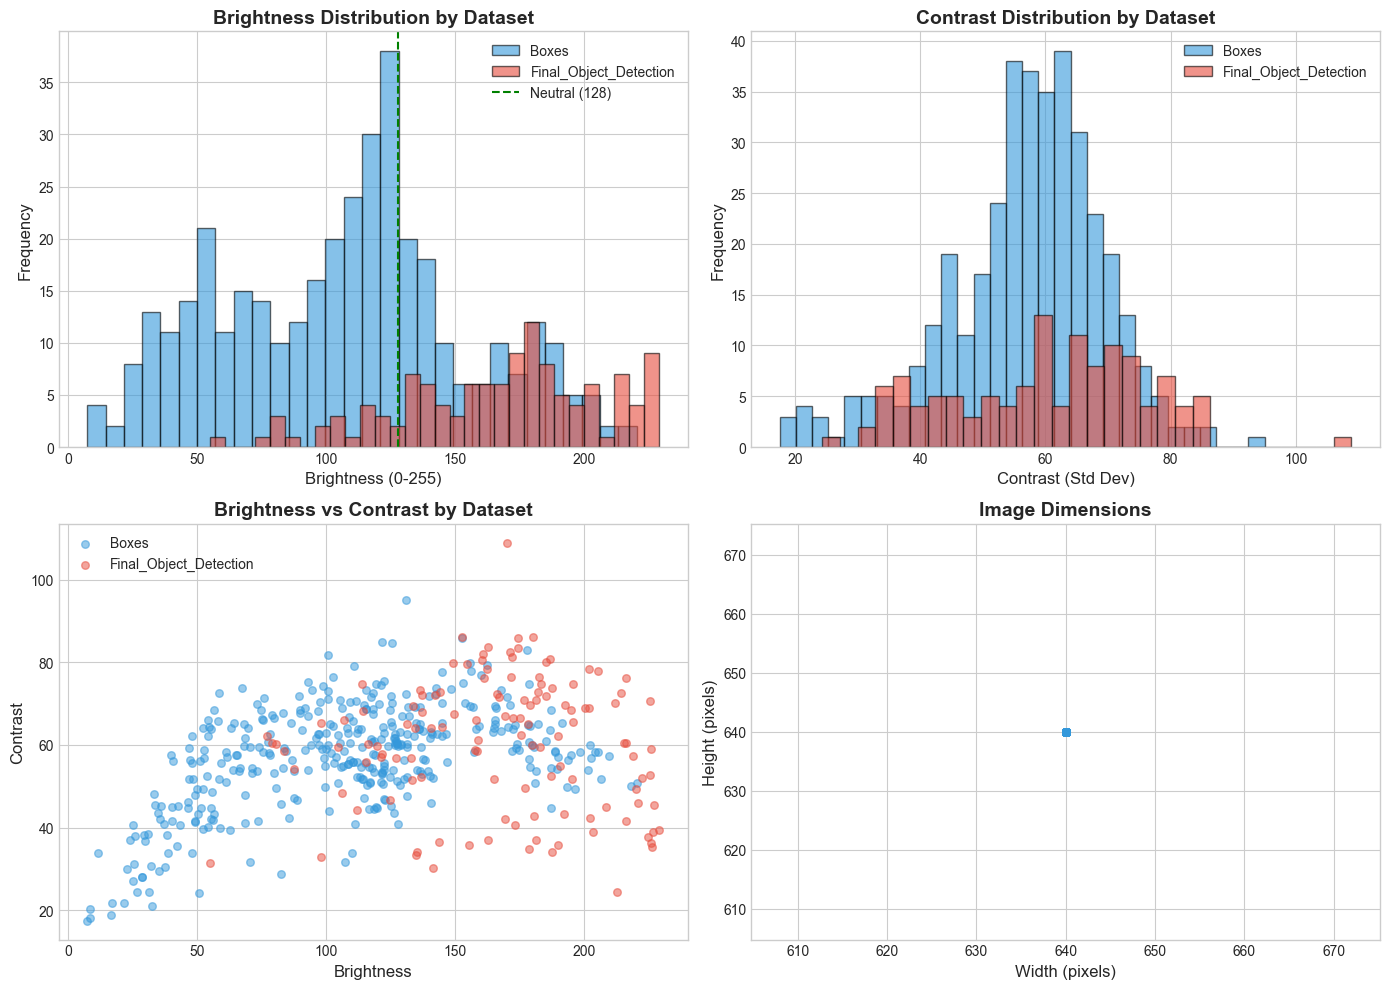


✓ Figure saved to docs/image_quality.png


In [19]:
# Image quality visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Brightness distribution
ax1 = axes[0, 0]
for dataset, color in zip(['Boxes', 'Final_Object_Detection'], ['#3498db', '#e74c3c']):
    subset = df_quality[df_quality['dataset'] == dataset]['brightness']
    ax1.hist(subset, bins=30, alpha=0.6, label=dataset, color=color, edgecolor='black')
ax1.axvline(128, color='green', linestyle='--', label='Neutral (128)')
ax1.set_xlabel('Brightness (0-255)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Brightness Distribution by Dataset', fontsize=14, fontweight='bold')
ax1.legend()

# Plot 2: Contrast distribution
ax2 = axes[0, 1]
for dataset, color in zip(['Boxes', 'Final_Object_Detection'], ['#3498db', '#e74c3c']):
    subset = df_quality[df_quality['dataset'] == dataset]['contrast']
    ax2.hist(subset, bins=30, alpha=0.6, label=dataset, color=color, edgecolor='black')
ax2.set_xlabel('Contrast (Std Dev)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Contrast Distribution by Dataset', fontsize=14, fontweight='bold')
ax2.legend()

# Plot 3: Brightness vs Contrast scatter
ax3 = axes[1, 0]
for dataset, color in zip(['Boxes', 'Final_Object_Detection'], ['#3498db', '#e74c3c']):
    subset = df_quality[df_quality['dataset'] == dataset]
    ax3.scatter(subset['brightness'], subset['contrast'], alpha=0.5, label=dataset, color=color, s=30)
ax3.set_xlabel('Brightness', fontsize=12)
ax3.set_ylabel('Contrast', fontsize=12)
ax3.set_title('Brightness vs Contrast by Dataset', fontsize=14, fontweight='bold')
ax3.legend()

# Plot 4: Image dimensions
ax4 = axes[1, 1]
ax4.scatter(df_quality['width'], df_quality['height'], alpha=0.5, c='#3498db', s=30)
ax4.set_xlabel('Width (pixels)', fontsize=12)
ax4.set_ylabel('Height (pixels)', fontsize=12)
ax4.set_title('Image Dimensions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../docs/image_quality.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved to docs/image_quality.png")


## 8. Dataset Comparison: Boxes vs Final_Object_Detection


In [20]:
# Statistical comparison between datasets
print("="*60)
print("DATASET COMPARISON")
print("="*60)

comparison = df_combined.groupby('dataset').agg({
    'box_count': ['count', 'mean', 'std', 'min', 'max', 'median']
}).round(2)

comparison.columns = ['Images', 'Avg Boxes', 'Std', 'Min', 'Max', 'Median']
print("\nBox Count Comparison:")
print(comparison)

# Bounding box characteristics comparison
print("\nBounding Box Characteristics:")
bbox_comparison = df_bbox.groupby('dataset').agg({
    'width': 'mean',
    'height': 'mean',
    'area': 'mean',
    'aspect_ratio': 'mean'
}).round(4)
bbox_comparison.columns = ['Avg Width', 'Avg Height', 'Avg Area', 'Avg Aspect Ratio']
print(bbox_comparison)


DATASET COMPARISON

Box Count Comparison:
                        Images  Avg Boxes    Std  Min  Max  Median
dataset                                                           
Boxes                     5006      15.00  16.94    1   98     8.0
Final_Object_Detection    1869       2.59   2.64    1   23     1.0

Bounding Box Characteristics:
                        Avg Width  Avg Height  Avg Area  Avg Aspect Ratio
dataset                                                                  
Boxes                      0.2383      0.2662    0.0935            1.1995
Final_Object_Detection     0.4236      0.4626    0.2591            0.9783


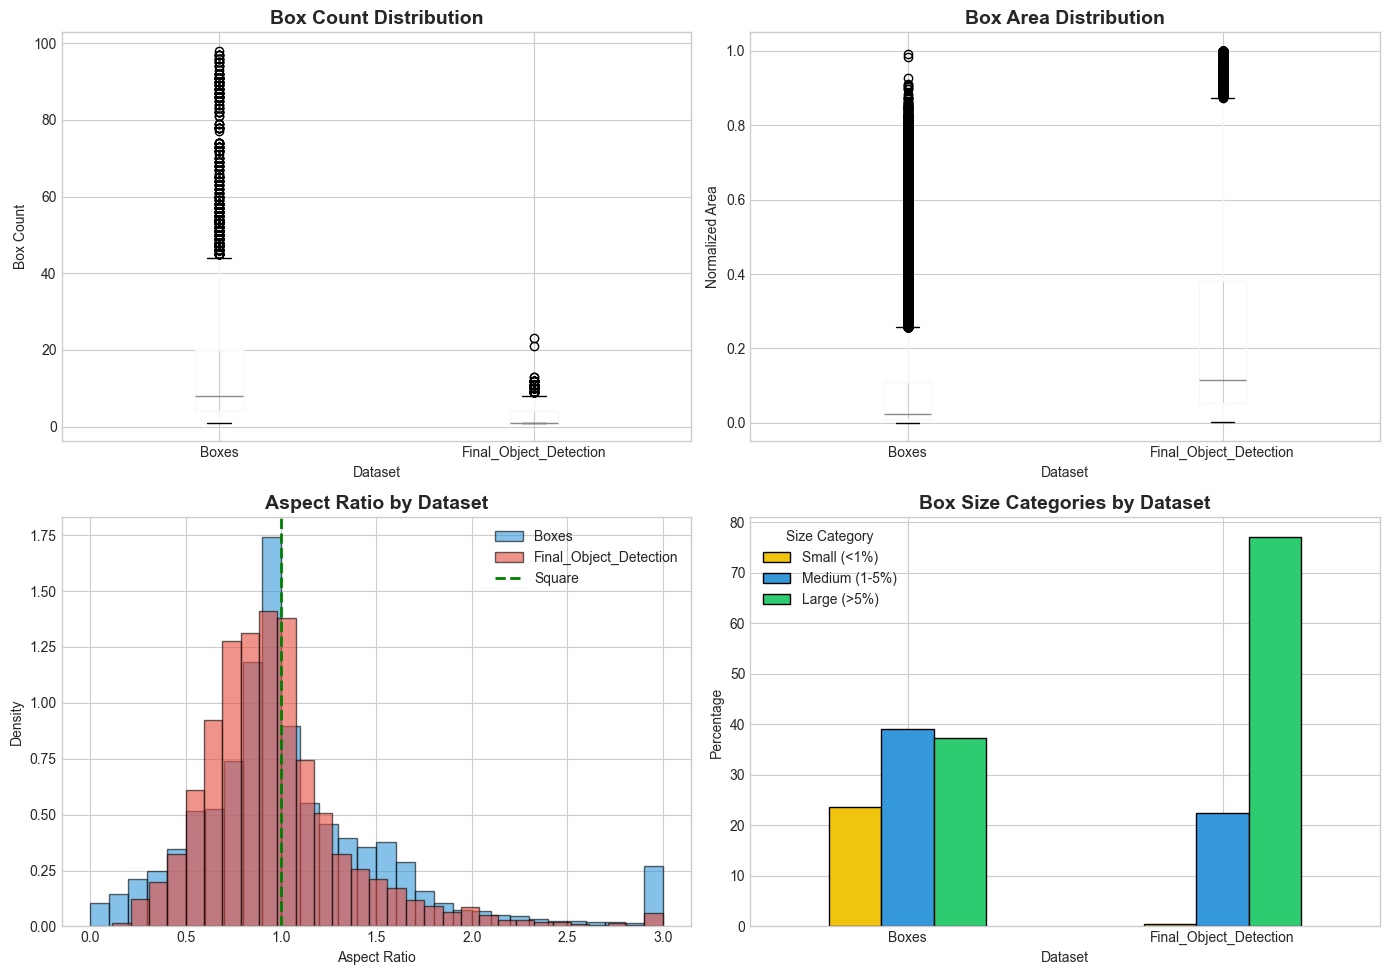


✓ Figure saved to docs/dataset_comparison.png


In [21]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Box count comparison
ax1 = axes[0, 0]
df_combined.boxplot(column='box_count', by='dataset', ax=ax1)
ax1.set_title('Box Count Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Dataset')
ax1.set_ylabel('Box Count')
plt.suptitle('')

# Area comparison
ax2 = axes[0, 1]
df_bbox.boxplot(column='area', by='dataset', ax=ax2)
ax2.set_title('Box Area Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Dataset')
ax2.set_ylabel('Normalized Area')
plt.suptitle('')

# Aspect ratio comparison
ax3 = axes[1, 0]
for dataset, color in zip(['Boxes', 'Final_Object_Detection'], ['#3498db', '#e74c3c']):
    subset = df_bbox[df_bbox['dataset'] == dataset]['aspect_ratio'].clip(0, 3)
    ax3.hist(subset, bins=30, alpha=0.6, label=dataset, color=color, edgecolor='black', density=True)
ax3.axvline(1.0, color='green', linestyle='--', linewidth=2, label='Square')
ax3.set_xlabel('Aspect Ratio')
ax3.set_ylabel('Density')
ax3.set_title('Aspect Ratio by Dataset', fontsize=14, fontweight='bold')
ax3.legend()

# Size category comparison
ax4 = axes[1, 1]
size_by_dataset = pd.crosstab(df_bbox['dataset'], df_bbox['size_category'], normalize='index') * 100
size_by_dataset.plot(kind='bar', ax=ax4, color=['#f1c40f', '#3498db', '#2ecc71'], edgecolor='black')
ax4.set_xlabel('Dataset')
ax4.set_ylabel('Percentage')
ax4.set_title('Box Size Categories by Dataset', fontsize=14, fontweight='bold')
ax4.legend(title='Size Category')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('../docs/dataset_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved to docs/dataset_comparison.png")


## 9. Key Findings & Recommendations


In [ ]:
# Generate summary report
print("="*70)
print("                    EDA SUMMARY & KEY FINDINGS")
print("="*70)

total_images = len(df_combined)
total_boxes = df_combined['box_count'].sum()
avg_boxes = df_combined['box_count'].mean()

print(f"""
📊 DATASET OVERVIEW
{'─'*50}
• Total images: {total_images:,}
• Total bounding boxes: {total_boxes:,}
• Average boxes per image: {avg_boxes:.1f}
• Split: Train {len(df_combined[df_combined['split']=='train']):,} | 
         Valid {len(df_combined[df_combined['split']=='valid']):,} | 
         Test {len(df_combined[df_combined['split']=='test']):,}

📦 BOX COUNT DISTRIBUTION
{'─'*50}
• Range: {df_combined['box_count'].min():.0f} to {df_combined['box_count'].max():.0f} boxes
• Median: {df_combined['box_count'].median():.0f} boxes
• 90th percentile: {df_combined['box_count'].quantile(0.90):.0f} boxes
• Most images have 5-20 boxes (typical pallet configuration)

📐 BOUNDING BOX CHARACTERISTICS
{'─'*50}
• Average box size: {df_bbox['area'].mean()*100:.1f}% of image area
• Average aspect ratio: {df_bbox['aspect_ratio'].mean():.2f} (boxes are slightly wider than tall)
• Size distribution: {df_bbox['size_category'].value_counts().idxmax()} boxes are most common

🔬 DATASET COMPARISON
{'─'*50}
• Boxes dataset: {len(df_boxes):,} images, avg {df_boxes['box_count'].mean():.1f} boxes/image
• Final_Object_Detection: {len(df_final):,} images, avg {df_final['box_count'].mean():.1f} boxes/image
• Combine both datasets for better model generalization

⚡ MODEL RECOMMENDATIONS
{'─'*50}
• YOLOv8 is well-suited for this task (avg {avg_boxes:.0f} objects/image)
• Consider increasing max_det parameter for high-count images
• Medium-sized boxes dominate - standard YOLO anchors should work well
• Image resolution is consistent - no special preprocessing needed

⚠️ POTENTIAL CHALLENGES
{'─'*50}
• High box count images ({len(df_combined[df_combined['box_count'] > 30]):,} images with >30 boxes)
• Overlapping/occluded boxes may affect detection
• Variable lighting conditions across datasets
""")


                    EDA SUMMARY & KEY FINDINGS

📊 DATASET OVERVIEW
──────────────────────────────────────────────────
• Total images: 6,875
• Total bounding boxes: 79,949
• Average boxes per image: 11.6
• Split: Train 4,812 | 
         Valid 1,374 | 
         Test 689

📦 BOX COUNT DISTRIBUTION
──────────────────────────────────────────────────
• Range: 1 to 98 boxes
• Median: 6 boxes
• 90th percentile: 30 boxes
• Most images have 5-20 boxes (typical pallet configuration)

📐 BOUNDING BOX CHARACTERISTICS
──────────────────────────────────────────────────
• Average box size: 10.4% of image area
• Average aspect ratio: 1.19 (boxes are slightly wider than tall)
• Size distribution: Large (>5%) boxes are most common

🔬 DATASET COMPARISON
──────────────────────────────────────────────────
• Boxes dataset: 5,006 images, avg 15.0 boxes/image
• Final_Object_Detection: 1,869 images, avg 2.6 boxes/image
• Recommendation: COMBINE both datasets for better model generalization

⚡ MODEL RECOMMENDATION

In [23]:
# Save key statistics to a file for reference
stats_summary = {
    'total_images': total_images,
    'total_boxes': int(total_boxes),
    'avg_boxes_per_image': round(avg_boxes, 2),
    'box_count_min': int(df_combined['box_count'].min()),
    'box_count_max': int(df_combined['box_count'].max()),
    'box_count_median': int(df_combined['box_count'].median()),
    'train_images': len(df_combined[df_combined['split']=='train']),
    'valid_images': len(df_combined[df_combined['split']=='valid']),
    'test_images': len(df_combined[df_combined['split']=='test']),
    'avg_box_width': round(df_bbox['width'].mean(), 4),
    'avg_box_height': round(df_bbox['height'].mean(), 4),
    'avg_box_area': round(df_bbox['area'].mean(), 4),
    'avg_aspect_ratio': round(df_bbox['aspect_ratio'].mean(), 3)
}

import json
with open('../docs/eda_statistics.json', 'w') as f:
    json.dump(stats_summary, f, indent=2)

print("✓ Statistics saved to docs/eda_statistics.json")
print("\n" + "="*70)
print("                    EDA NOTEBOOK COMPLETE ✓")
print("="*70)


✓ Statistics saved to docs/eda_statistics.json

                    EDA NOTEBOOK COMPLETE ✓
